In [1]:
import cv2
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.layers import AveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import keras
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import argparse
import os

In [2]:
DIR_TRAIN = "dataset-cropped/Train/"
DIR_TEST = "dataset-cropped/Test/"

In [3]:
label_data = pd.read_csv("dataset-cropped/label.csv")
label_data

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_001,159,9,2
1,TPS_002,112,87,2
2,TPS_003,173,27,3
3,TPS_004,207,20,3
4,TPS_005,213,30,4
...,...,...,...,...
495,TPS_496,11,150,60
496,TPS_497,20,105,18
497,TPS_498,11,168,24
498,TPS_499,39,130,32


In [4]:
images = []
labels = []

df = pd.read_csv("dataset-cropped/label.csv")

for tps in os.listdir(DIR_TRAIN):
    for paslon in os.listdir(os.path.join(DIR_TRAIN, tps)):
        for section in os.listdir(os.path.join(DIR_TRAIN, tps, paslon)):
            path = os.path.join(DIR_TRAIN, tps, paslon, section)

            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (40, 240))
            img = cv2.GaussianBlur(img, (5, 5), 0)
            # imt = cv2.medianBlur(img, 5)

            th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 2)
            # cv2.floodFill(th, None, (0, 0), 123, )
            
            th = th / 255.0
            images.append(th)
    
    curr_tps = df[df['tps'] == tps]
    for col in (['suara_paslon_1', 'suara_paslon_2', 'suara_paslon_3']):
        label_str = '{:03d}'.format(curr_tps[col].values[0])
        labels.extend([int(n) for n in label_str])

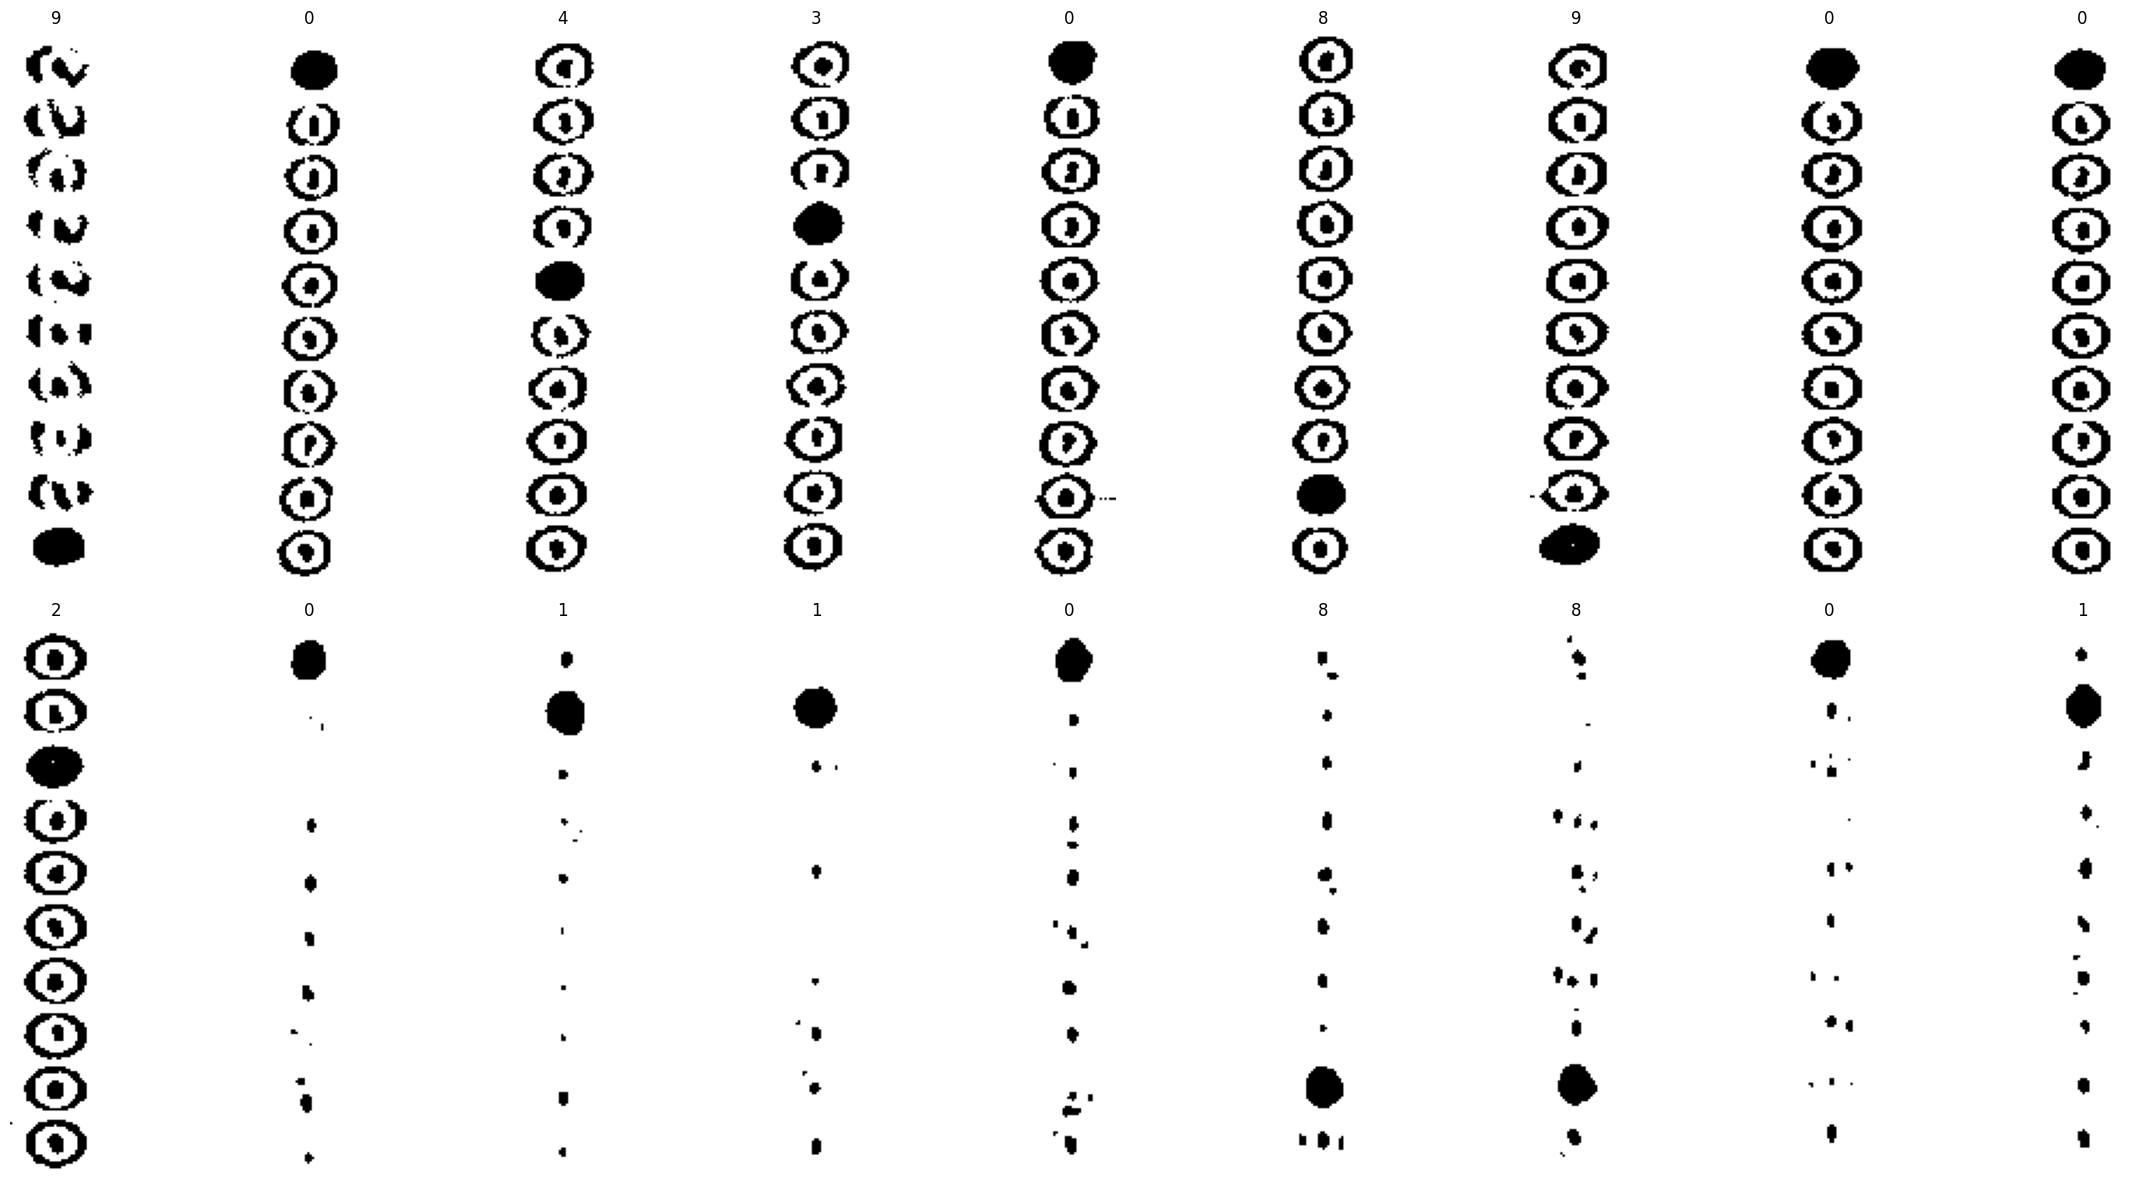

In [5]:
plt.figure(figsize=(24, 12))
for i in range (18):
    plt.subplot(2, 9, i + 1)
    plt.axis("off")
    fig = plt.imshow(images[i+1520], 'gray')
    plt.title(labels[i+1520])

plt.tight_layout()
plt.show()

In [6]:
base = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 40, 3))
x = base.output
# x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x) 

model = Model(inputs=base.input, outputs=predictions)

for layer in base.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 40, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 46, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 20, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 120, 20, 64)  256         ['conv1_conv[0][0]']         

c:\Users\LEGION\anaconda3\envs\deep_learning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 15, 3, 256)  0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 15, 3, 256)   590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 15, 3, 256)  1024        ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 15, 3, 256)  0           ['conv4_block1_2_bn[0][0]']      
 n)       

In [7]:


images = np.array(images)
labels = np.array(labels)

images = np.repeat(images[..., np.newaxis], 3, -1)

labels = keras.utils.to_categorical(labels, num_classes=10)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train  = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [8]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/50
104/104 [==============================] - 8s 42ms/step - loss: 1.7237 - accuracy: 0.4125 - val_loss: 1.1803 - val_accuracy: 0.6022
Epoch 2/50
104/104 [==============================] - 3s 28ms/step - loss: 1.1135 - accuracy: 0.6398 - val_loss: 0.8464 - val_accuracy: 0.8858
Epoch 3/50
104/104 [==============================] - 3s 29ms/step - loss: 0.8335 - accuracy: 0.7583 - val_loss: 0.5761 - val_accuracy: 0.9231
Epoch 4/50
104/104 [==============================] - 3s 31ms/step - loss: 0.6468 - accuracy: 0.8340 - val_loss: 0.4512 - val_accuracy: 0.9387
Epoch 5/50
104/104 [==============================] - 3s 29ms/step - loss: 0.5287 - accuracy: 0.8737 - val_loss: 0.3606 - val_accuracy: 0.9639
Epoch 6/50
104/104 [==============================] - 4s 34ms/step - loss: 0.4428 - accuracy: 0.8978 - val_loss: 0.3045 - val_accuracy: 0.9712
Epoch 7/50
104/104 [==============================] - 3s 30ms/step - loss: 0.3754 - accuracy: 0.9203 - val_loss: 0.2510 - val_accuracy: 0.9748

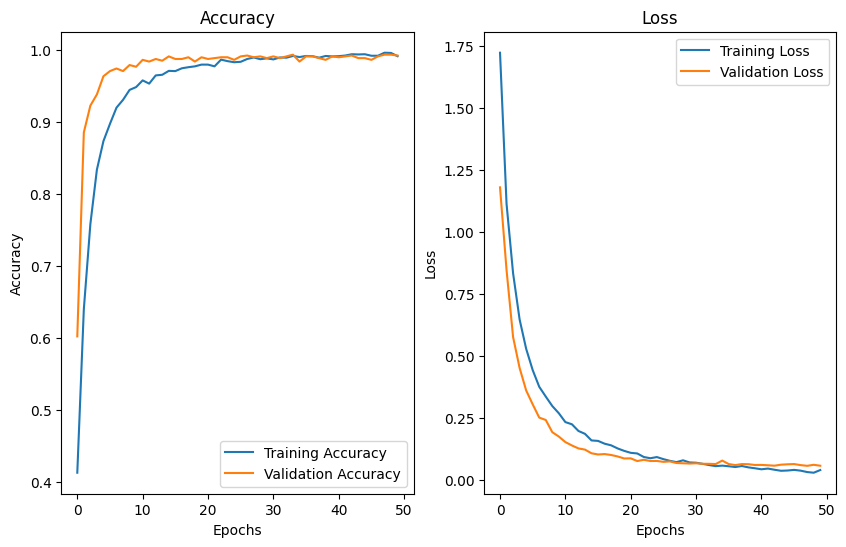

In [9]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
model.save("models/ResNet50PreprocessInput")
model.save("models/ResNet50PreprocessInput.h5")

INFO:tensorflow:Assets written to: models/ResNet50PreprocessInput\assets


INFO:tensorflow:Assets written to: models/ResNet50PreprocessInput\assets
